In [1]:
#Importing the main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os
import re

Using TensorFlow backend.


In [2]:
#Taking note of the current versions used
print(tf.__version__)
print(keras.__version__)

2.2.0
2.3.1


In [3]:
data=pd.read_json('dataset.json',lines=True)
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


Now, this dataset needs preprocessing before feeding the suitable data to an LSTM. This includes :

Getting the oraganisation of the artice, and save only that.
Remove all special characters from the sentences, to be left with plain text (wil be done automatically using tokenizer).

In [4]:
#Removing the link, and putting the organisation in its place
data["organization"]=data["article_link"].apply(lambda x: re.findall(r"\w+",x)[2])
data=data.drop(["article_link"],axis=1)
data.head()

,is_sarcastic,headline,organization
0,1,thirtysomething scientists unveil doomsday clo...,theonion
1,0,dem rep. totally nails why congress is falling...,huffingtonpost
2,0,eat your veggies: 9 deliciously different recipes,huffingtonpost
3,1,inclement weather prevents liar from getting t...,theonion
4,1,mother comes pretty close to using word 'strea...,theonion


In [5]:
#Now, before any other preprocessing is done, let it be verified if whether or not the data is balanced
#Checking the nature of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   organization  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


Data is complete. There is no null or empty values.

In [6]:
#Understanding the data, to see if it is skewed or not
data.describe()

,is_sarcastic
count,28619.000000
mean,0.476397
std,0.499451
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Since the column "is_sarcastic" takes only binary values, and the mean is 0.4763, or approximately 47.6%, the data is not heavily skewed.

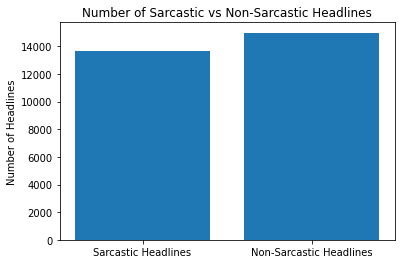

In [7]:
#The above statements can be visualised as
sarcastic=0
for i in range(len(data["is_sarcastic"])):
    if data["is_sarcastic"].iloc[i]==1:
        sarcastic+=1
normal=len(data["is_sarcastic"])-sarcastic
label_values={"Sarcastic Headlines" : sarcastic, "Non-Sarcastic Headlines" : normal}
plt.bar(label_values.keys(),label_values.values(),align="center")
plt.title("Number of Sarcastic vs Non-Sarcastic Headlines")
plt.ylabel("Number of Headlines")
plt.show()

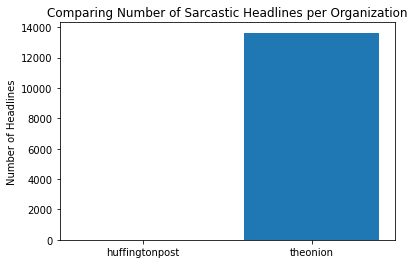

In [8]:
#Now, to ignore the effect of the organization on whether a headline is sarcastic, we need to check for skew
#list(data["organization"].unique()) returns only two organizations 'huffingtonpost' and 'theonion'
org_labels={"huffingtonpost" : 0, "theonion" : 0}
for i in range(len(data["organization"])):
    if data["is_sarcastic"].iloc[i]==1:
        org_labels[data["organization"].iloc[i]]+=1
plt.bar(org_labels.keys(),org_labels.values(),align="center")
plt.title("Comparing Number of Sarcastic Headlines per Organization")
plt.ylabel("Number of Headlines")
plt.show()

This makes a very interesting observation, that ALL the sarcastic headlines come from "theonion", and none from "huffingtonpost". This renders the segregation useless, as they basically represent nothing but the labels themselves.

In [9]:
#Dropping the "organization" column
data=data.drop(["organization"],axis=1)
data.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


The next step is to tokenize all of the headlines. This means : '''This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...''' 

In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

#Note that the training data/test data split will be done later

num_words=20000
max_sentence_len=300
tokenizer=Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(list(data["headline"]))
X=tokenizer.texts_to_sequences(list(data["headline"]))
X=pad_sequences(X,maxlen=max_sentence_len)
Y=to_categorical(data["is_sarcastic"].values)
print("The number of unique words in the text corpus dictionary : {}".format(len(tokenizer.word_index)))
print("The shape of the trainable data : {}".format(X.shape))
print("The shape of the labels for the data is : {}".format(Y.shape))

The number of unique words in the text corpus dictionary : 30884
The shape of the trainable data : (28619, 300)
The shape of the labels for the data is : (28619, 2)


It is observed that the number of unique wordsin the text dictionary made using tokenizer is 30,884, and the maximum allowed as per this cell is 20000. This basically means that the other 10,884 words are discarded, due to them being less frequent.

In [11]:
#Getting the pre trained GloVe embeddings into the embedding matrix from the link used in this cell

embedding_words={}
file=open('/content/drive/My Drive/Colab Notebooks/glove.6B.300d.txt','r', encoding="utf-8")
for line in file:
    #There are a number of lines containing embeddings for each word
    info=line.split(" ")
    #The first value in each line of the file is a unique word
    word=info[0]
    #The rest are embedding values of a specific dimension (to be displayed)
    embedding_values=np.array(info[1:],dtype="float32")
    #Storing these values
    embedding_words[word]=embedding_values
file.close()
print("The dimension/length of the embedding vector for each word is : {}"
     .format(len(embedding_words["go"])))

The dimension/length of the embedding vector for each word is : 300


Now, from these "embedding_words", the embedding matrix is obtained by running the cell below:

In [0]:
from keras.layers import Embedding
from keras.initializers import Constant

#The length/dimension of the embedding vector was found to be 300 after running the previous cell
embedding_dim=len(embedding_words["go"]) #or simply 300
#Initialising the embedding matrix
embedding_matrix=np.zeros((num_words,embedding_dim))
#Forming the embedding matrix by using the embedding vectors for only those words in the text corpus of the data  
for word,i in tokenizer.word_index.items():
    if i>num_words:
        continue
    embedding_vector=embedding_words.get(word)
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector

In [13]:
#Creating the embedding layer further with the help of keras
#These embeddings are made non-trainable as they are pre trained to highly optimized values
embeddings=Embedding(num_words,embedding_dim,embeddings_initializer=Constant(embedding_matrix),
                    input_length=max_sentence_len,trainable=False)
#Getting the shape of the embedding matrix (should be (num_words,embedding_dim)=(20000,300))
print("The shape of the embedding matrix is {}".format(embedding_matrix.shape))

The shape of the embedding matrix is (20000, 300)


In [0]:
#Building the model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, LSTM, Bidirectional, Conv1D, MaxPooling1D 

model=Sequential()
model.add(embeddings)
model.add(Conv1D(32,3,activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Flatten())
model.add(Dense(30,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2,activation="sigmoid"))
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [0]:
#Splittting the data into training and testing sets before fitting the model
#Using a 80% - 20% split for the data
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2)

In [16]:
batch_size=128 #Using a batch size of 128, during gradient descent
num_epochs=10 #Number of iterations/epochs over the training set

history=model.fit(x_train,y_train,batch_size=batch_size,epochs=num_epochs,validation_data=(x_test,y_test))

Train on 22895 samples, validate on 5724 samples
Epoch 1/10
22895/22895 [==============================] - 231s 10ms/step - loss: 0.5564 - accuracy: 0.7149 - val_loss: 0.4571 - val_accuracy: 0.7721
Epoch 2/10
22895/22895 [==============================] - 227s 10ms/step - loss: 0.4397 - accuracy: 0.8025 - val_loss: 0.3806 - val_accuracy: 0.8244
Epoch 3/10
22895/22895 [==============================] - 230s 10ms/step - loss: 0.3951 - accuracy: 0.8276 - val_loss: 0.3694 - val_accuracy: 0.8316
Epoch 4/10
22895/22895 [==============================] - 227s 10ms/step - loss: 0.3692 - accuracy: 0.8402 - val_loss: 0.3584 - val_accuracy: 0.8409
Epoch 5/10
22895/22895 [==============================] - 229s 10ms/step - loss: 0.3472 - accuracy: 0.8528 - val_loss: 0.3495 - val_accuracy: 0.8401
Epoch 6/10
22895/22895 [==============================] - 231s 10ms/step - loss: 0.3329 - accuracy: 0.8570 - val_loss: 0.3501 - val_accuracy: 0.8435
Epoch 7/10
22895/22895 [==============================] -

In [17]:
test_performance=model.evaluate(x_test,y_test)
print("The loss of the model on the test set : {}".format(test_performance[0]))
print("The accuracy of the model on the test set : {}%".format(test_performance[1]*100))

5724/5724 [==============================] - 14s 2ms/step
The loss of the model on the test set : 0.3395444588341303
The accuracy of the model on the test set : 85.35988926887512%


In [18]:
#Visualising the summary of the network used
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          6000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 298, 32)           28832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 149, 32)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 149, 32)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 149, 256)          164864    
_________________________________________________________________
flatten_1 (Flatten)          (None, 38144)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)               

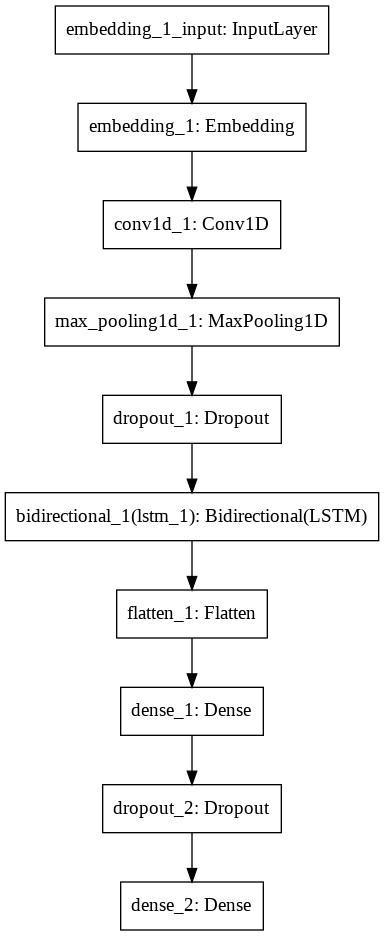

In [19]:
#Visualising the network architecture of the model
from keras.utils import plot_model
plot_model(model,to_file="bidir_lstm.jpg")

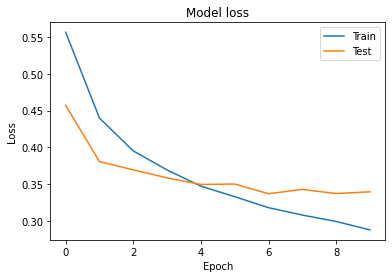

In [20]:
#Visualising the loss of the model, throughout the training process
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig("modelloss_sarcasmdetection.jpg")

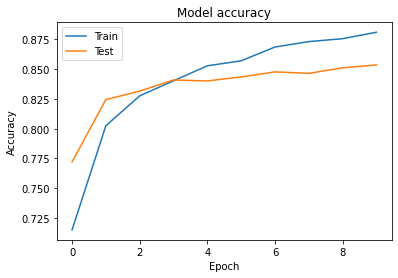

In [21]:
#Visualising the accuracy of the model, throughout the training process
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("modelacc_sarcasmdetection.jpg")

In [22]:
#Checking the validity of this model on some own made up headlines

my_headline1="Of course you meant that" #Meant to be sarcastic
my_headline2="The facts imply that the suspect used a gun" #Meant to be non-sarcastic
my_headline3="It looks like Trump is very affectionate" #Meant to be sarcastic
my_headline4="The economy is on the brink of collapse" #Meant to be non-sarcastic

my_headline11=tokenizer.texts_to_sequences(my_headline1)
my_headline22=tokenizer.texts_to_sequences(my_headline2)
my_headline33=tokenizer.texts_to_sequences(my_headline3)
my_headline44=tokenizer.texts_to_sequences(my_headline4)

my_headline11=pad_sequences(my_headline11,maxlen=max_sentence_len,dtype="int32",value=0)
my_headline22=pad_sequences(my_headline22,maxlen=max_sentence_len,dtype="int32",value=0)
my_headline33=pad_sequences(my_headline33,maxlen=max_sentence_len,dtype="int32",value=0)
my_headline44=pad_sequences(my_headline44,maxlen=max_sentence_len,dtype="int32",value=0)

prediction1=model.predict(my_headline11,batch_size=1)[0]
prediction2=model.predict(my_headline22,batch_size=1)[0]
prediction3=model.predict(my_headline33,batch_size=1)[0]
prediction4=model.predict(my_headline44,batch_size=1)[0]

if np.argmax(prediction1)==1:
    print("The headline - " + my_headline1 + " : Not Sarcastic")
else:
    print("The headline - " + my_headline1 + " : Sarcastic")
    
if np.argmax(prediction2)==1:
    print("The headline - " + my_headline2 + " : Not Sarcastic")
else:
    print("The headline - " + my_headline2 + " : Sarcastic")

if np.argmax(prediction3)==1:
    print("The headline - " + my_headline3 + " : Not Sarcastic")
else:
    print("The headline - " + my_headline3 + " : Sarcastic")
    
if np.argmax(prediction4)==1:
    print("The headline - " + my_headline4 + " : Not Sarcastic")
else:
    print("The headline - " + my_headline4 + " : Sarcastic")

The headline - Of course you meant that : Sarcastic
The headline - The facts imply that the suspect used a gun : Sarcastic
The headline - It looks like Trump is very affectionate : Sarcastic
The headline - The economy is on the brink of collapse : Sarcastic


In [0]:
#Saving the model to the disk
model_json = model.to_json()
with open("model_sarcasmdetection.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_sarcasmdetection.h5")